# PetFinder Kaggle Competition (baseline)

An active kernel of this notebook on Kaggle CLI can be found [here](https://www.kaggle.com/waydegg/baseline-tabular-learner-with-fastai-v1) if you want actually run through it yourself without downloading the data. If you want to download the dataset and run this jupyter notebook you'll have to make a Kaggle account, register for the FindPets Competition, and then download the data yourself in the `path` directory. It's quite a large dataset.

There's a lot to be improved with this notebook. It's simply just a baseline model to demonstrate a tabular learner with fastai v1.

In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [101]:
from fastai.tabular import *

In [102]:
torch.cuda.set_device(0)
print(f'Using GPU#{torch.cuda.current_device()}')

Using GPU#0


## Data Cleaning

In [169]:
os.makedirs('data/pet_finder', exist_ok=True)
path = Path('data/pet_finder'); path

PosixPath('data/pet_finder')

You'll need to have a Kaggle account to download the competition data.

In [104]:
path.ls()

[PosixPath('data/pet_finder/test_sentiment'),
 PosixPath('data/pet_finder/state_labels.csv'),
 PosixPath('data/pet_finder/color_labels.csv'),
 PosixPath('data/pet_finder/breed_labels.csv'),
 PosixPath('data/pet_finder/train_images'),
 PosixPath('data/pet_finder/train_sentiment'),
 PosixPath('data/pet_finder/test_images'),
 PosixPath('data/pet_finder/train_metadata'),
 PosixPath('data/pet_finder/train'),
 PosixPath('data/pet_finder/test'),
 PosixPath('data/pet_finder/test_metadata')]

In [105]:
# Cleaning file structure
%time
for x in test:
        if str(x)[-3:] == 'zip':
            name_full = str(x).split('/')
            name = name_full[-1][:-4]
            
            os.makedirs(path/name, exist_ok=True)
            os.system(f'mv {path/name_full[-1]} {path/name}')      
            # need to unzip files too?

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


In [106]:
train_df = pd.read_csv(path/'train'/'train.csv')
test_df = pd.read_csv(path/'test'/'test.csv')
samp_df = pd.read_csv(path/'test'/'sample_submission.csv')

In [107]:
train_df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [108]:
train_df['PetID'].head()

0    86e1089a3
1    6296e909a
2    3422e4906
3    5842f1ff5
4    850a43f90
Name: PetID, dtype: object

In [109]:
test_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,1,Puppy,2,307,0,1,1,0,0,2,...,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0
1,2,London,24,266,0,1,2,7,0,2,...,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0
2,2,Snowball,20,266,0,2,7,0,0,2,...,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,Snowball... doesn't look so good (she is healt...,72000c4c5,1.0
3,2,Malibu,5,266,252,2,1,6,7,2,...,1,1,1,100,41326,4475f31553f0170229455e3c5645644f,0,"Malibu: Female, Local Mix, 4-5 months, vaccina...",e147a4b9f,1.0
4,1,Lala Girl,6,307,0,2,1,2,7,2,...,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,LALA! That's my name. I'm a 6 month old girl d...,43fbba852,1.0


In [110]:
samp_df.head()

,PetID,AdoptionSpeed
0,378fcc4fc,0
1,73c10e136,0
2,72000c4c5,0
3,e147a4b9f,0
4,43fbba852,0


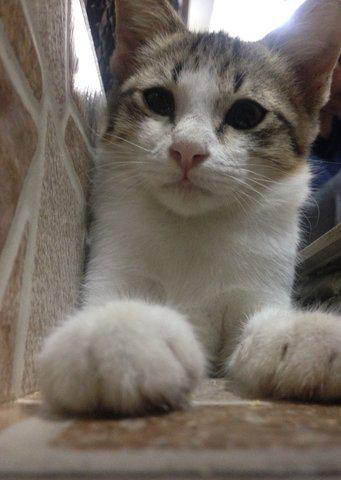

In [111]:
open_image(path/'train_images'/os.listdir(path/'train_images')[99])

In [112]:
train_df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [120]:
train_df['Fee'].head()

0    100
1      0
2      0
3    150
4      0
Name: Fee, dtype: int64

In [124]:
len(train_df)

14993

### Databunch

In [135]:
dep_var = 'AdoptionSpeed'
cat_names = ['Type', 'Name', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize',
             'FurLength', 'State', 'RescuerID', 'PetID']
cont_names = ['Age', 'Fee', 'VideoAmt', 'PhotoAmt']
procs = [FillMissing, Categorify, Normalize]

# Not including 'Description'

In [136]:
test = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names)

In [137]:
data = (TabularList.from_df(train_df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
        .random_split_by_pct(0.2, seed=42)
        .label_from_df(cols=dep_var)
        .add_test(test)
        .databunch()
)

In [138]:
data.show_batch(rows=10)

Type,Name,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,State,RescuerID,PetID,Age,Fee,VideoAmt,PhotoAmt,target
1,Pixy,307,0,2,4,0,0,2,1,41401,c00756f2bdd8fa88fc9f07a8309f7d5d,1e83794bd,-0.3006,-0.2803,-0.1697,0.3123,2
1,Handsome Boy,307,0,1,1,7,0,2,2,41330,60689896aa0edff3a4f05b890bdafd26,a091487fb,1.3898,-0.2803,-0.1697,0.3123,3
2,Neslo,265,0,2,1,4,7,1,2,41326,cdf2cd8d67e53bf6e5088dcb2de317d6,0defc5386,-0.4641,-0.2803,-0.1697,-0.2573,1
2,Aki N Deador,265,0,3,1,7,0,2,2,41326,ca780cca6ad489f76a49110c5c93f615,650a1a505,-0.4096,-0.2803,-0.1697,-0.2573,1
2,Baby,266,0,1,1,6,7,2,1,41326,c622191468a875711ee4d05b0ceb3761,a4e103d6d,-0.1915,-0.2803,-0.1697,-0.2573,4
2,Danish,265,0,2,1,2,0,2,2,41324,7d6435989d7f2adf802e3ee53709b12c,9c68827b5,0.6809,-0.2803,-0.1697,-0.8268,4
2,#na#,265,266,1,6,7,0,2,2,41401,c2c6cdbdeb122dbbfc2c289a17573cae,275df2552,-0.4096,-0.2803,-0.1697,0.0275,3
2,#na#,266,266,3,1,6,7,2,1,41326,0b65c9795c3f969870365b68c102fb81,a972114e1,-0.5187,-0.2803,-0.1697,0.3123,4
1,#na#,103,307,2,1,4,0,2,2,41401,88da1210e021a5cf43480b074778f3bc,29af2b6ec,-0.4641,-0.2803,-0.1697,-0.8268,2
1,#na#,307,0,2,1,7,0,2,2,41401,b607eb7ae80024c9a6a3975bd41a4f8b,dcba09ff1,-0.5732,-0.2803,-0.1697,0.3123,1


## Learner

In [148]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


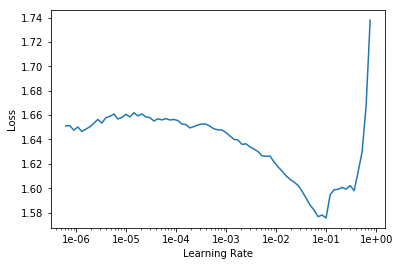

In [140]:
learn.lr_find()
learn.recorder.plot()

In [149]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.328914,1.330066,0.425951


In [150]:
learn.save('first')

In [157]:
learn.load('first');

## Submission

In [165]:
test_preds = np.argmax(learn.get_preds(DatasetType.Test)[0],axis=1)
test_preds

tensor([4, 4, 4,  ..., 1, 1, 4])

In [166]:
sub_df = pd.DataFrame(data={'PetID': pd.read_csv(path/'test'/'test.csv')['PetID'],
                            'AdoptionSpeed': test_preds})
sub_df.head()

,PetID,AdoptionSpeed
0,378fcc4fc,4
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4


In [168]:
sub_df.to_csv(path/'submission.csv', index=False)